In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import zipfile
#from google.colab import drive
#drive.mount('/content/drive')
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/TestTask/catsdogs.zip", 'r')
#zip_ref.extractall("/content/dataset")
#zip_ref.close()

Mounted at /content/drive


Выполнение обучения и тестирования модели проводилось на домашнем компьютере со следующими характеристиками: Nvidia RTX 2070 Super GPU, 6 CPU cores (Intel Core i5-8400 CPU @ 3.40GHz) и 64 GB DDR4

Для начала инициализируем функции переноса данных на GPU, а также функцию отображения изображения и предсказанного тега

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def show_img_label(image, label):
    plt.figure(figsize = (10,10))
    plt.title('Предсказанный класс: {0}'.format(label))
    plt.imshow(image)

Определим кастомный загрузчик данных на GPU

In [3]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [4]:
device = get_default_device()

Определим трансофрмации данных отдельно для тренировочного, отдельно для тестового набора данных

In [5]:
train_transform=transforms.Compose([
  transforms.RandomRotation(10),
  transforms.RandomHorizontalFlip(),
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [6]:
test_transform=transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])
])

Загрузим и проверим наши данные

In [7]:
train_data=datasets.ImageFolder(root = ('dataset/Cat_Dog_data/train'), transform = train_transform)

In [8]:
test_data=datasets.ImageFolder(root = ('dataset/Cat_Dog_data/test'), transform = test_transform)

In [9]:
class_names = train_data.classes
class_names

['cat', 'dog']

In [10]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

In [11]:
len_train = len(train_data)
len_test = len(test_data)

In [12]:
print("Размер тренировочного набора данных: {0}".format(len_train))
print("Размер тестового набора данных: {0}".format(len_test))

Размер тренировочного набора данных: 22500
Размер тестового набора данных: 2500


In [13]:
inv_normalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                  std = [1/0.229, 1/0.224, 1/0.225])

Отобразим данные для проверки корректности их загрузки

In [14]:
for images, labels in train_loader:
    break

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images, nrow = 5)

Label: [1 1 1 0 1 1 0 1 1 1]
Class: dog dog dog cat dog dog cat dog dog dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


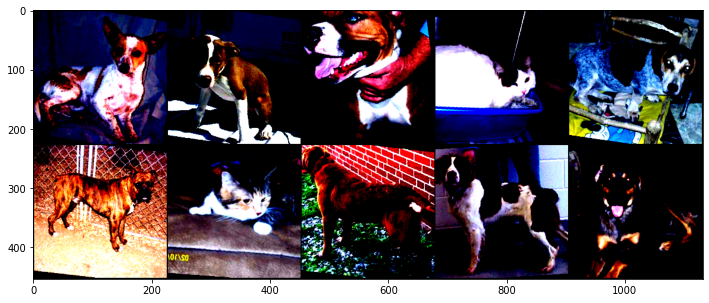

In [15]:
plt.figure(figsize = (12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

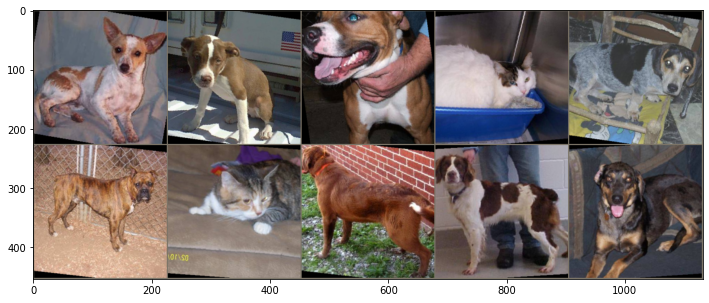

In [16]:
im=inv_normalize(im)
plt.figure(figsize = (12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Чтобы не изобретать модель с нуля воспользуемся transfer learning, модель для до обучения выберем с сайта paperswithcode, из списка state of the art моделей для решения задачи классификации выберем оптимальную по соотношению количества весов, размера и точности. Выбранная модель достаточно современный визуальный трансформер VIT_B.
До неё также были проверены стандартные модели встроенные в torchvision: EfficientNet_b2, GoogleLeNet, AlexNet, но в ходе экспериментов они показали меньшую точность чем выбранная VIT_B

In [17]:
vit_b = models.vit_b_32(weights = models.ViT_B_32_Weights)

Отключим градиент чтобы предотвратить обучение основной части сети

In [18]:
for param in vit_b.parameters():
    param.requires_grad = False

In [19]:
vit_b

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Заменим последний слой на небольшой классификатор под решаемую задачу, конечной функцией активации выберем LogSoftMax так как она позволяет достичь лучшей производительности на более слабом железе и имеет большую стабильность будучи логарифмической

In [20]:
torch.manual_seed(42)

vit_b.heads = nn.Sequential(nn.Linear(768,256),
                          nn.ReLU(),
                          nn.Dropout(p = 0.5),
                          nn.Linear(256, 2),
                          nn.LogSoftmax(dim = 1))
vit_b

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Критерий CrossEntropyLoss был выбран, так как обладает наибольшим качеством работы при решении задачи класификации, оптимизатор Adam является достаточно универсальным и позволяет достичь хорошей производительности и результатов на большей части задач, а scheduler был выбран в связи с быстрой сходимостью модели и необходимости в более маленьких lr при выходе на плато точности

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_b.heads.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2, factor = 0.2)

In [50]:
vit_b = to_device(vit_b, device)
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [51]:
import time
start_time = time.time()
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy_bth = []
loss_bth = []
epochs = 20
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train,y_train) in enumerate(train_loader):
    b += 1
    y_pred = vit_b(X_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 200 == 0:
      acc = trn_corr.item() * 100 / (10 * b)
      accuracy_bth.append(acc)
      loss_bth.append(loss.cpu().detach().numpy())
      print(f'epoch: {i:2}  batch: {b:4} [{10 * b:6}/8000]  loss: {loss.item():10.8f}  accuracy: {acc:7.3f}%')
  loss = loss.cpu().detach().numpy()
  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b, (X_test,y_test) in enumerate(test_loader):
      b += 1
    y_val = vit_b(X_test)
    predicted = torch.max(y_val.data,1)[1]
    btach_corr = (predicted==y_test).sum()
    tst_corr += btach_corr
  
  loss = criterion(y_val, y_test)
  loss = loss.cpu().detach().numpy()
  scheduler.step(loss)
  test_losses.append(loss)
  test_correct.append(tst_corr)
  if i % 2 == 0:
    torch.save(vit_b.state_dict(), 'vit_b_' + str(i) + '_epoch')



print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/8000]  loss: 0.00000000  accuracy:  99.900%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00000000  accuracy:  99.875%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.00000000  accuracy:  99.917%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.00000000  accuracy:  99.912%
epoch:  0  batch: 1000 [ 10000/8000]  loss: 0.00895636  accuracy:  99.900%
epoch:  0  batch: 1200 [ 12000/8000]  loss: 0.67162079  accuracy:  99.883%
epoch:  0  batch: 1400 [ 14000/8000]  loss: 0.00000000  accuracy:  99.864%
epoch:  0  batch: 1600 [ 16000/8000]  loss: 0.00000000  accuracy:  99.856%
epoch:  0  batch: 1800 [ 18000/8000]  loss: 0.00050124  accuracy:  99.850%
epoch:  0  batch: 2000 [ 20000/8000]  loss: 0.00000002  accuracy:  99.845%
epoch:  0  batch: 2200 [ 22000/8000]  loss: 0.00000148  accuracy:  99.827%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.00000001  accuracy:  99.750%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.00079768  accuracy:  99.775%
epoch:  1  batch:  600 [ 

In [52]:
torch.save(vit_b.state_dict(), 'vit_b_20epoch')

Text(0.5, 1.0, 'Тестовые потери по эпохам')

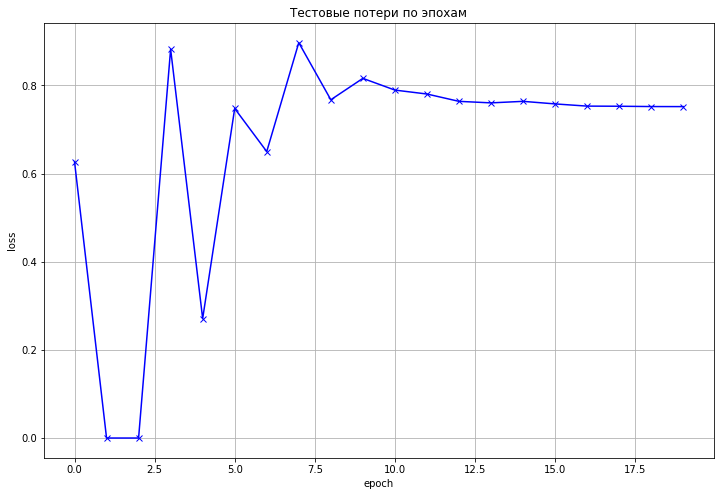

In [133]:
plt.figure(figsize = (12,8))
plt.plot(test_losses, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Тестовые потери по эпохам')

Text(0.5, 1.0, 'Тренировочные потери по эпохам')

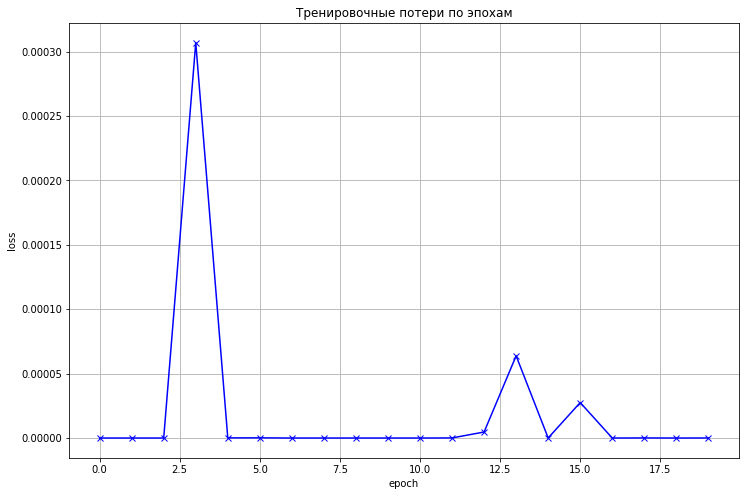

In [134]:
plt.figure(figsize = (12,8))
plt.plot(train_losses, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Тренировочные потери по эпохам')

Text(0.5, 1.0, 'Точность по эпохам')

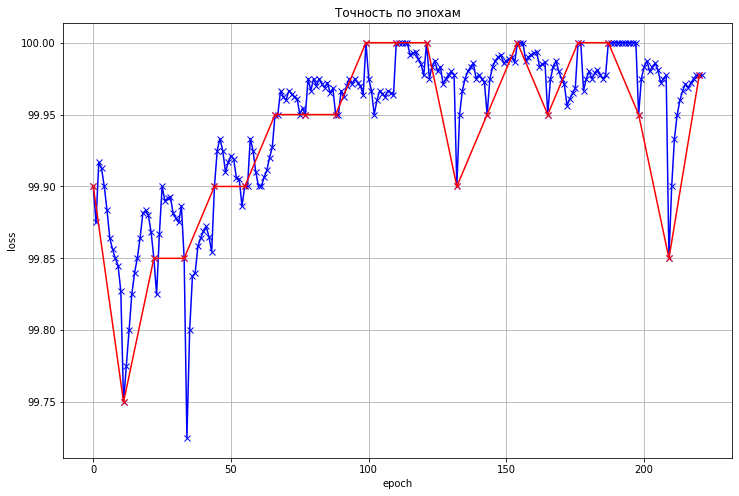

In [90]:
accuracy_bth.append(accuracy_bth[-1])
plt.figure(figsize = (12,8))
plt.plot(accuracy_bth, '-bx')
plt.plot(range(0,221,11),accuracy_bth[::11], '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Точность по эпохам')

In [60]:
vit_b = models.vit_b_32()
vit_b.heads = nn.Sequential(nn.Linear(768,256),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(256,2),
                            nn.LogSoftmax(dim=1))
checkpoint = torch.load('vit_b_10epoch')
vit_b.load_state_dict(checkpoint)

<All keys matched successfully>

In [116]:
total = 0
correct = 0
accuracy = 0
pred_conf = []
real_conf = []
vit_b = to_device(vit_b, device)
with torch.no_grad():
    vit_b.eval()
    for b, (x, y) in enumerate(test_loader):
        x = to_device(x, device)
        y = to_device(y, device)
        outputs = vit_b(x)
        breakpoint()
        predicted = torch.max(outputs.data,1)[1]
        total += len(y)
        correct += (predicted == y).sum()

        buf_y = y.cpu().detach().numpy()
        buf_predicted = predicted.cpu().detach().numpy()
        for i in range(len(y)):
            pred_conf.append(buf_predicted[i])
            real_conf.append(buf_y[i])
                
accuracy = 100 * correct / float(total)
print('Итоговая точность модели на тестовом наборе: {0}'.format(accuracy))

Итоговая точность модели на тестовом наборе: 99.0


<Figure size 1080x1080 with 0 Axes>

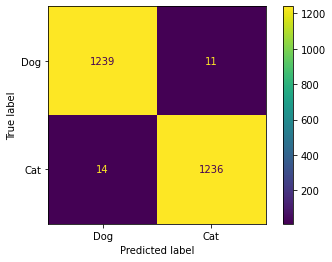

In [132]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(real_conf, pred_conf)
plt.figure(figsize = (15, 15))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Dog', 'Cat'])
cm_display.plot()

Метрика accuracy говорит нам, сколько данных их тестового набора данных мы определелили верно, precision это доля объектов являющихся положительными и названная положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашла сеть.
Как мы видим из полученных результатов, значения всех метрик находятся на высоком уровне, а значит обученная сеть корректно определяет класс изображения с высокой точностью

In [126]:
print('Метрика accuracy: {0}'.format(metrics.accuracy_score(real_conf, pred_conf)))
print('Метрика precision: {0}'.format(metrics.precision_score(real_conf, pred_conf)))
print('Метрика recall: {0}'.format(metrics.recall_score(real_conf, pred_conf)))

Метрика accuracy: 0.99
Метрика precision: 0.9911788291900562
Метрика recall: 0.9888


Напишем функцию для инференса модели и протестируем её на собственных изображениях

In [30]:
from PIL import Image

def infer(path_to_model, path_to_image):
  model = models.vit_b_32()
  model.heads = nn.Sequential(nn.Linear(768,256),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(256,2),
                              nn.LogSoftmax(dim=1))
  model.load_state_dict(torch.load(path_to_model))
  model.eval()
  transform = transforms.Compose([
                  transforms.Resize(224),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485,0.456,0.406],
                                        [0.229,0.224,0.225])
  ])
  dict_labels = {0:'cat', 1:'dog'}
  inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                      std=[1/0.229, 1/0.224, 1/0.225])
  im = Image.open(path_to_image)
  im = transform(im)
  preds = model(im.reshape(1, 3, 224, 224))
  predicted = torch.max(preds.data,1)[1]
  label = dict_labels[predicted.item()]
  im = inv_normalize(im).permute(1, 2, 0)
  return im, label

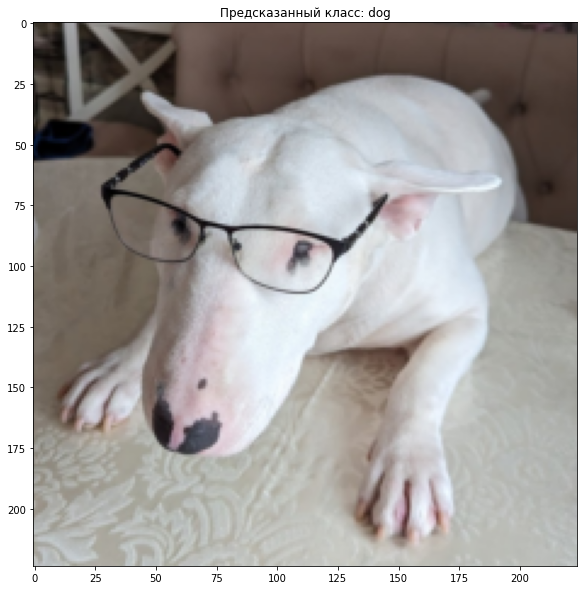

In [128]:
image1, label1 = infer('trained_models/vit_b_20epoch','test_dog.jpg')
show_img_label(image1, label1)

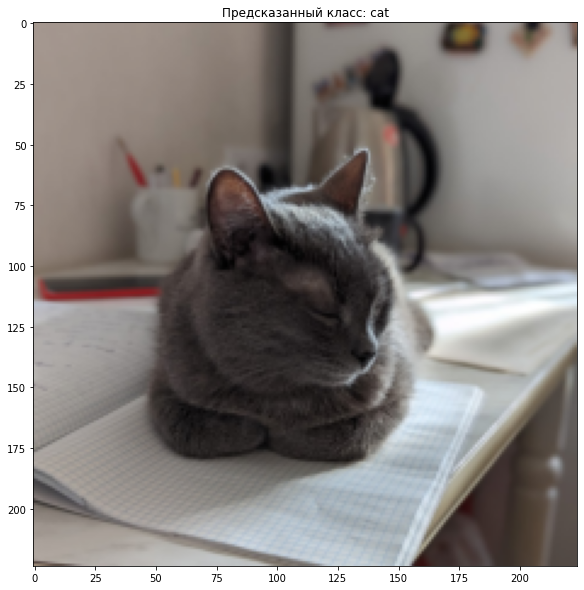

In [129]:
image2, label2 = infer('trained_models/vit_b_20epoch','test_cat.jpg')
show_img_label(image2, label2)

In [127]:
!nvidia-smi

Sun Oct 22 14:55:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   34C    P8              15W / 185W |   3199MiB /  8192MiB |     17%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--